In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Text(0.5, 1.0, 'Данные после нормировки')

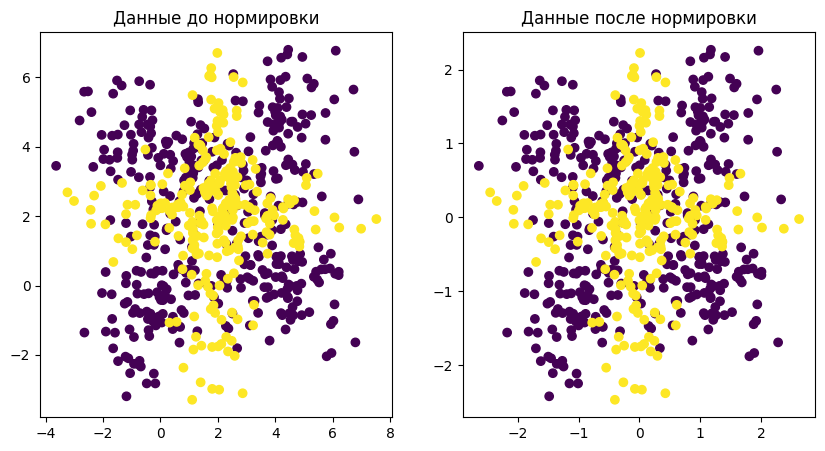

In [2]:
df = pd.read_csv('data_lab3/data_lab3v03.csv', names=['feature1', 'feature2', 'result'])
X, y = df.iloc[:, :-1].values, np.where(df.iloc[:, -1].values == -1, 0, 1).reshape(-1, 1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(X[:, 0], X[:, 1], c=y)
ax[0].set_title('Данные до нормировки')
scaler = StandardScaler()
X = scaler.fit_transform(X)
ax[1].scatter(X[:, 0], X[:, 1], c=y)
ax[1].set_title('Данные после нормировки')

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, test_size=0.4, shuffle=True, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, train_size=0.25, test_size=0.75, shuffle=True, random_state=42)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
X_val = torch.Tensor(X_val)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)
y_val = torch.Tensor(y_val)

print(f'Количество объектов первого класса в тренировочной выборке: {np.sum(np.where(y_train == 0, 1, 0))}')
print(f'Количество объектов второго класса в тренировочной выборке: {np.sum(np.where(y_train == 1, 1, 0))}')

print(f'Количество объектов первого класса в валидационной выборке: {np.sum(np.where(y_val == 0, 1, 0))}')
print(f'Количество объектов второго класса в валидационной выборке: {np.sum(np.where(y_val == 1, 1, 0))}')

print(f'Количество объектов первого класса в тестовой выборке: {np.sum(np.where(y_test == 0, 1, 0))}')
print(f'Количество объектов второго класса в тестовой выборке: {np.sum(np.where(y_test == 1, 1, 0))}')

Количество объектов первого класса в тренировочной выборке: 228
Количество объектов второго класса в тренировочной выборке: 162
Количество объектов первого класса в валидационной выборке: 126
Количество объектов второго класса в валидационной выборке: 69
Количество объектов первого класса в тестовой выборке: 46
Количество объектов второго класса в тестовой выборке: 19


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 5)
        self.fc2 = nn.Linear(5, 5)
        self.fc3 = nn.Linear(5, 1)
        self.activation = nn.Softplus()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
def calculate_accuracy(y_pred, y_real):
    return np.sum(np.where(y_pred == y_real, 1, 0)) / len(y_real)

def calculate_epsilon(y_pred, y_real):
    return np.sum(np.where(y_pred == y_real, 0, 1)) / len(y_real)

In [7]:
model = Net()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.5, momentum=0.3)

train_loss_arr = []
val_loss_arr = []
test_loss_arr = []

train_eps_arr = []
val_eps_arr = []
test_eps_arr = []

epochs = 9000
for epoch in range(epochs):
    model.train()
    output = model(X_train)
    loss = criterion(output, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        train_out = model(X_train)
        train_pred = torch.round(torch.sigmoid(train_out))
        train_loss = criterion(train_out, y_train)
        train_eps = calculate_epsilon(train_pred, y_train)
        train_acc = calculate_accuracy(train_pred, y_train)
        train_loss_arr.append(train_loss)
        train_eps_arr.append(train_eps)

        val_out = model(X_val)
        val_pred = torch.round(torch.sigmoid(val_out))
        val_loss = criterion(val_out, y_val)
        val_eps = calculate_epsilon(val_pred, y_val)
        val_acc = calculate_accuracy(val_pred, y_val)
        val_loss_arr.append(val_loss)
        val_eps_arr.append(val_eps)

        test_out = model(X_test)
        test_pred = torch.round(torch.sigmoid(test_out))
        test_loss = criterion(test_out, y_test)
        test_eps = calculate_epsilon(test_pred, y_test)
        test_acc = calculate_accuracy(test_pred, y_test)
        test_loss_arr.append(test_loss)
        test_eps_arr.append(test_eps)

    if (epoch + 1) % (epochs / 10) == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}, Train accuracy: {(train_acc * 100):.2f}%, Test_accuracy: {(test_acc * 100):.2f}%, Validation accuracy: {(val_acc * 100):.2f}%, Test loss: {test_loss:.4f}, Validation loss: {val_loss:.4f}, Train epsilon: {train_eps:.4f}, Test epsilon: {test_eps:.4f}, Validation epsilon: {val_eps:.4f}')

Epoch 900, Loss: 0.5811, Train accuracy: 72.82%, Test_accuracy: 73.85%, Validation accuracy: 72.82%, Test loss: 0.5732, Validation loss: 0.5847, Train epsilon: 0.2718, Test epsilon: 0.2615, Validation epsilon: 0.2718
Epoch 1800, Loss: 0.4518, Train accuracy: 77.44%, Test_accuracy: 81.54%, Validation accuracy: 74.36%, Test loss: 0.3924, Validation loss: 0.4515, Train epsilon: 0.2256, Test epsilon: 0.1846, Validation epsilon: 0.2564
Epoch 2700, Loss: 0.4030, Train accuracy: 81.28%, Test_accuracy: 80.00%, Validation accuracy: 75.38%, Test loss: 0.4175, Validation loss: 0.4290, Train epsilon: 0.1872, Test epsilon: 0.2000, Validation epsilon: 0.2462
Epoch 3600, Loss: 0.3989, Train accuracy: 80.77%, Test_accuracy: 80.00%, Validation accuracy: 75.38%, Test loss: 0.4346, Validation loss: 0.4315, Train epsilon: 0.1923, Test epsilon: 0.2000, Validation epsilon: 0.2462
Epoch 4500, Loss: 0.3972, Train accuracy: 81.54%, Test_accuracy: 80.00%, Validation accuracy: 76.41%, Test loss: 0.4512, Validati

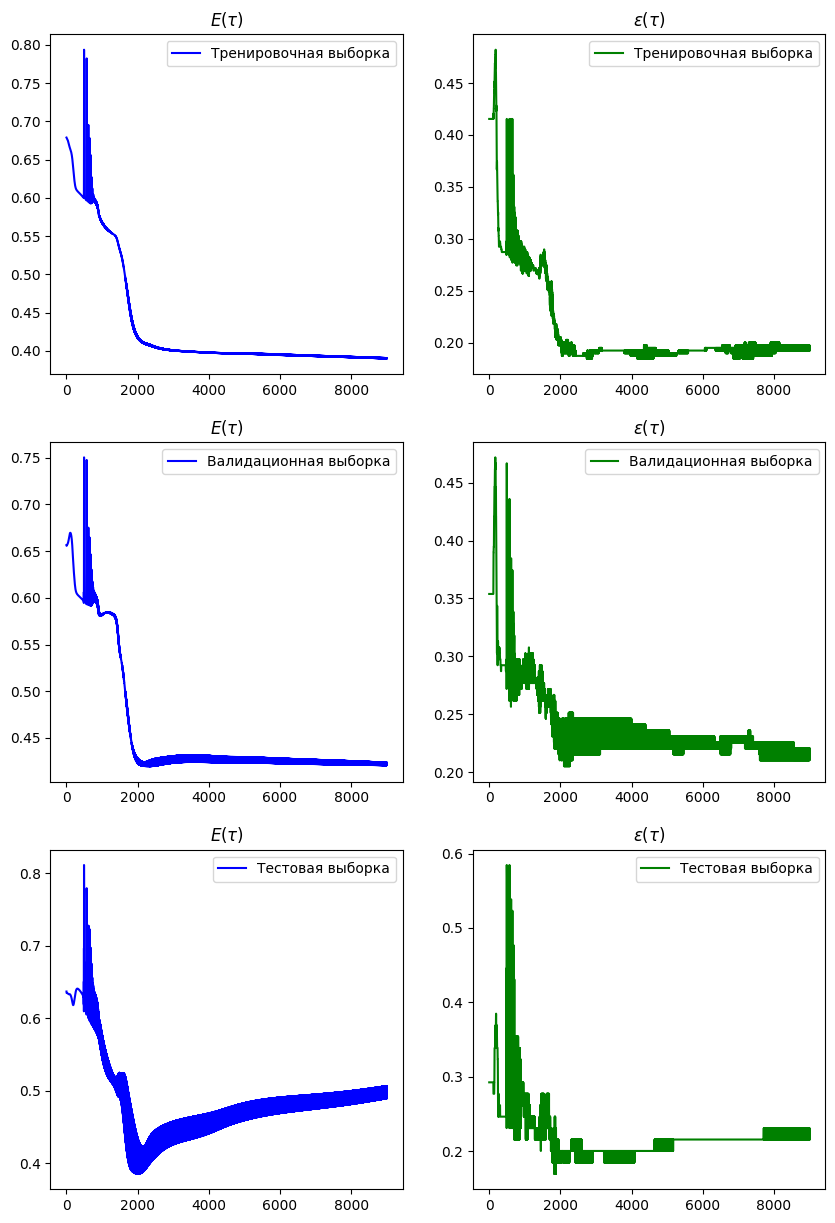

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
ax[0, 0].plot(train_loss_arr, color='blue', label='Тренировочная выборка')
ax[0, 0].set_title(r'$E(\tau)$')
ax[0, 1].plot(train_eps_arr, color='green', label='Тренировочная выборка')
ax[0, 1].set_title(r'$\varepsilon(\tau)$')

ax[1, 0].plot(val_loss_arr, color='blue', label='Валидационная выборка')
ax[1, 0].set_title(r'$E(\tau)$')
ax[1, 1].plot(val_eps_arr, color='green', label='Валидационная выборка')
ax[1, 1].set_title(r'$\varepsilon(\tau)$')

ax[2, 0].plot(test_loss_arr, color='blue', label='Тестовая выборка')
ax[2, 0].set_title(r'$E(\tau)$')
ax[2, 1].plot(test_eps_arr, color='green', label='Тестовая выборка')
ax[2, 1].set_title(r'$\varepsilon(\tau)$')

for i in range(3):
    for j in range(2):
        ax[i, j].legend()

In [9]:
print(f'Среднее значение функции потерь на тренировочной, валидационной и тестовой выборках: {train_loss_arr[-1]}, {val_loss_arr[-1]}, {test_loss_arr[-1]}')
print(f'Ошибка классификации на тренировочной, валидационной и тестовой выборках: {train_eps_arr[-1]}, {val_eps_arr[-1]}, {test_eps_arr[-1]}')

Среднее значение функции потерь на тренировочной, валидационной и тестовой выборках: 0.39005589485168457, 0.4234601557254791, 0.4895040988922119
Ошибка классификации на тренировочной, валидационной и тестовой выборках: 0.19230769230769232, 0.2205128205128205, 0.2153846153846154


In [10]:
def get_metrics(y_pred, y_real):
    TP = np.count_nonzero((y_pred == 1) & (y_pred == y_real))
    TN = np.count_nonzero((y_pred == 0) & (y_pred == y_real))
    FP = np.count_nonzero((y_pred == 1) & (y_pred != y_real))
    FN = np.count_nonzero((y_pred == 0) & (y_pred != y_real))
    return TP, TN, FP, FN

In [11]:
train_predicted = torch.round(torch.sigmoid(model(X_train)))
TP, TN, FP, FN = get_metrics(train_predicted.detach().numpy(), y_train.detach().numpy())
print(f'TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}')
model

TP: 129, TN: 186, FP: 42, FN: 33


Net(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
  (activation): Softplus(beta=1, threshold=20)
)

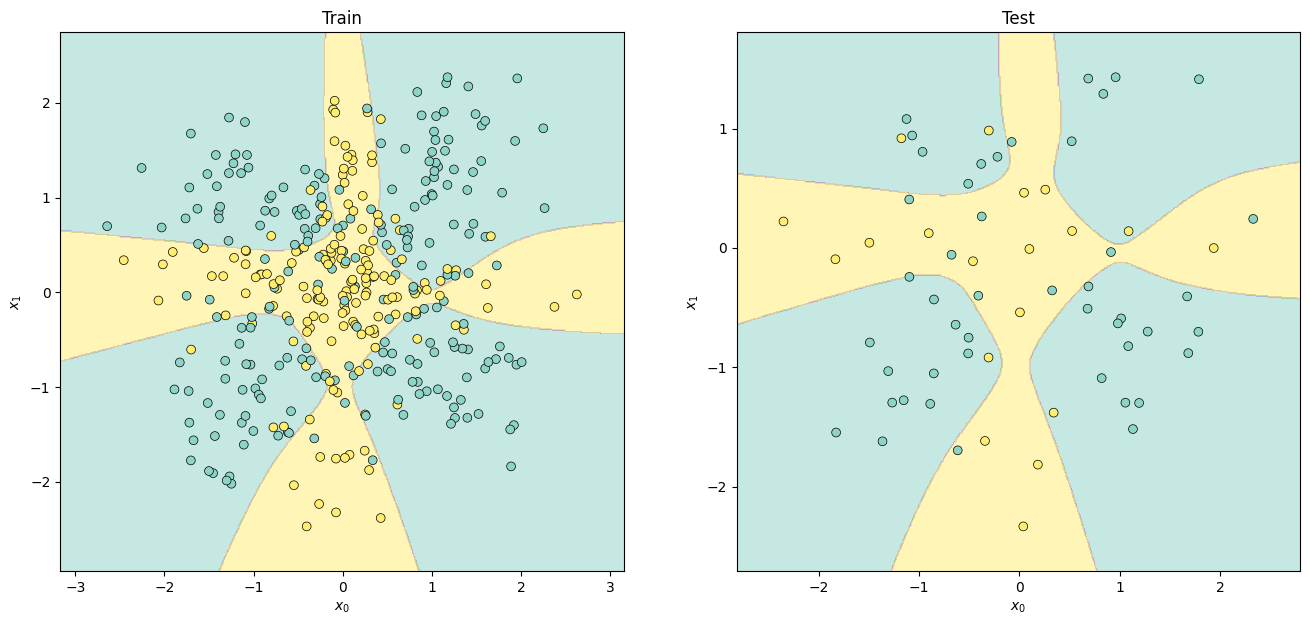

In [13]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    margin_x1 = (X[:, 0].max() - X[:, 0].min()) * 0.1
    margin_x2 = (X[:, 1].max() - X[:, 1].min()) * 0.1

    x_min, x_max = X[:, 0].min() - margin_x1, X[:, 0].max() + margin_x1
    y_min, y_max = X[:, 1].min() - margin_x2, X[:, 1].max() + margin_x2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 501), np.linspace(y_min, y_max, 501))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))

    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap="Set3", alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap="Set3", ec='black', alpha=1, lw=0.5)

    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


def train_test_model_plot(model, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(16, 7))

    plt.subplot(1, 2, 1)
    plt.title("Train")
    plot_decision_boundary(model, X_train, y_train)

    plt.subplot(1, 2, 2)
    plt.title("Test")
    plot_decision_boundary(model, X_test, y_test)


train_test_model_plot(model, X_train, y_train, X_test, y_test)

In [14]:
model2 = Net()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model2.parameters(), lr=0.5, momentum=0.3)

train_loss_arr = []
val_loss_arr = []
test_loss_arr = []

train_eps_arr = []
val_eps_arr = []
test_eps_arr = []

epochs = 9000
for epoch in range(epochs):
    model2.train()
    output = model2(X_train)
    loss = criterion(output, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model2.eval()
    with torch.inference_mode():
        train_out = model2(X_train)
        train_pred = torch.round(torch.sigmoid(train_out))
        train_loss = criterion(train_out, y_train)
        train_eps = calculate_epsilon(train_pred, y_train)
        train_acc = calculate_accuracy(train_pred, y_train)
        train_loss_arr.append(train_loss)
        train_eps_arr.append(train_eps)

        val_out = model2(X_val)
        val_pred = torch.round(torch.sigmoid(val_out))
        val_loss = criterion(val_out, y_val)
        val_eps = calculate_epsilon(val_pred, y_val)
        val_acc = calculate_accuracy(val_pred, y_val)
        val_loss_arr.append(val_loss)
        val_eps_arr.append(val_eps)

        test_out = model2(X_test)
        test_pred = torch.round(torch.sigmoid(test_out))
        test_loss = criterion(test_out, y_test)
        test_eps = calculate_epsilon(test_pred, y_test)
        test_acc = calculate_accuracy(test_pred, y_test)
        test_loss_arr.append(test_loss)
        test_eps_arr.append(test_eps)

    if (epoch + 1) % (epochs / 10) == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}, Train accuracy: {(train_acc * 100):.2f}%, Test_accuracy: {(test_acc * 100):.2f}%, Validation accuracy: {(val_acc * 100):.2f}%, Test loss: {test_loss:.4f}, Validation loss: {val_loss:.4f}, Train epsilon: {train_eps:.4f}, Test epsilon: {test_eps:.4f}, Validation epsilon: {val_eps:.4f}')

Epoch 900, Loss: 0.5947, Train accuracy: 71.79%, Test_accuracy: 78.46%, Validation accuracy: 72.31%, Test loss: 0.5846, Validation loss: 0.6010, Train epsilon: 0.2821, Test epsilon: 0.2154, Validation epsilon: 0.2769
Epoch 1800, Loss: 0.4127, Train accuracy: 81.03%, Test_accuracy: 84.62%, Validation accuracy: 75.90%, Test loss: 0.3710, Validation loss: 0.4283, Train epsilon: 0.1897, Test epsilon: 0.1538, Validation epsilon: 0.2410
Epoch 2700, Loss: 0.3973, Train accuracy: 80.26%, Test_accuracy: 78.46%, Validation accuracy: 75.90%, Test loss: 0.3985, Validation loss: 0.4249, Train epsilon: 0.1974, Test epsilon: 0.2154, Validation epsilon: 0.2410
Epoch 3600, Loss: 0.3935, Train accuracy: 80.51%, Test_accuracy: 76.92%, Validation accuracy: 75.90%, Test loss: 0.4241, Validation loss: 0.4284, Train epsilon: 0.1949, Test epsilon: 0.2308, Validation epsilon: 0.2410
Epoch 4500, Loss: 0.3916, Train accuracy: 80.51%, Test_accuracy: 78.46%, Validation accuracy: 76.92%, Test loss: 0.4385, Validati

In [15]:
print(f'Среднее значение функции потерь на тренировочной, валидационной и тестовой выборках: {train_loss_arr[-1]}, {val_loss_arr[-1]}, {test_loss_arr[-1]}')
print(f'Ошибка классификации на тренировочной, валидационной и тестовой выборках: {train_eps_arr[-1]}, {val_eps_arr[-1]}, {test_eps_arr[-1]}')

Среднее значение функции потерь на тренировочной, валидационной и тестовой выборках: 0.3856811821460724, 0.4217061996459961, 0.4771909713745117
Ошибка классификации на тренировочной, валидационной и тестовой выборках: 0.20256410256410257, 0.22564102564102564, 0.2


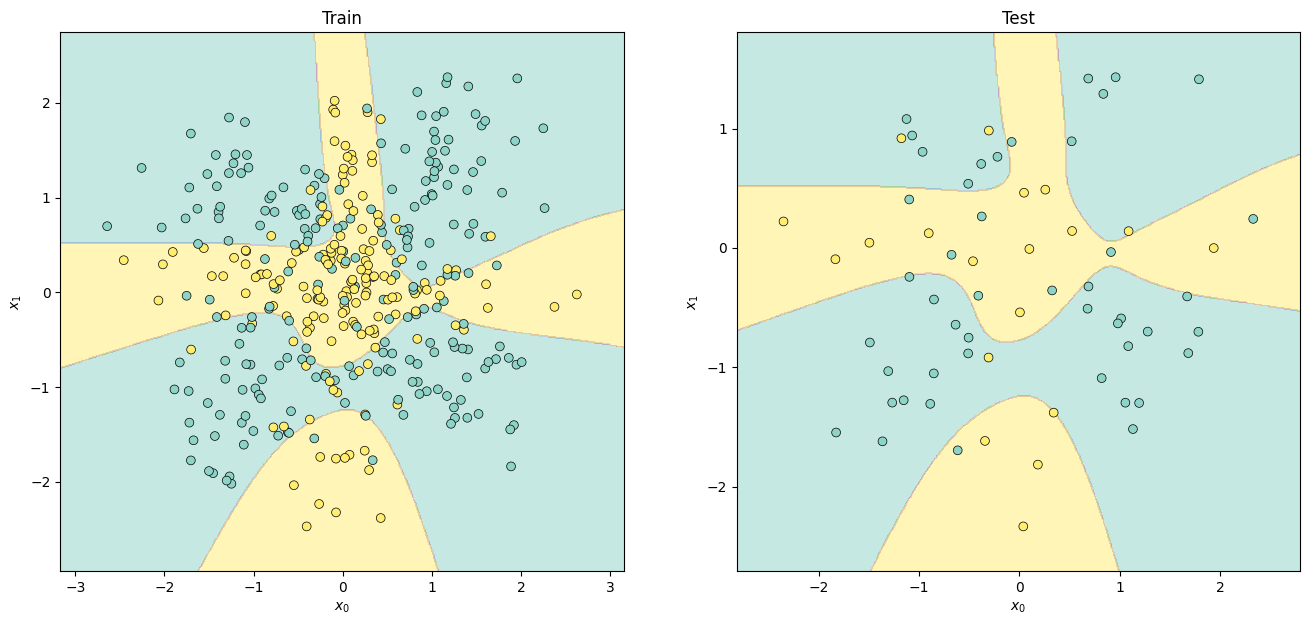

In [16]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    margin_x1 = (X[:, 0].max() - X[:, 0].min()) * 0.1
    margin_x2 = (X[:, 1].max() - X[:, 1].min()) * 0.1

    x_min, x_max = X[:, 0].min() - margin_x1, X[:, 0].max() + margin_x1
    y_min, y_max = X[:, 1].min() - margin_x2, X[:, 1].max() + margin_x2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 501), np.linspace(y_min, y_max, 501))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))

    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap="Set3", alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap="Set3", ec='black', alpha=1, lw=0.5)

    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


def train_test_model_plot(model, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(16, 7))

    plt.subplot(1, 2, 1)
    plt.title("Train")
    plot_decision_boundary(model, X_train, y_train)

    plt.subplot(1, 2, 2)
    plt.title("Test")
    plot_decision_boundary(model, X_test, y_test)


train_test_model_plot(model2, X_train, y_train, X_test, y_test)